In [109]:
import json
import mysql.connector
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import re
import string
import random

In [211]:
RANDOM_SEED = 42
CACHE_DIR = '../cache/'

In [3]:
cnx = mysql.connector.connect(
  host='localhost',
  user='scraper',
  database='vk_scrap'
)

cursor = cnx.cursor()

In [19]:
BATCH_SIZE = 10000

cursor.execute("select count(*) from posts where DATE(date) > '2023-01-01'")
total = cursor.fetchall()[0][0]

In [46]:
df = pd.DataFrame(columns=['text', 'vk_wall_id', 'vk_post_id', 'attachment_types'])

new_row1 = {}
for i in tqdm(range((total + BATCH_SIZE - 1) // BATCH_SIZE + 1)):
  query = f'select * from posts where DATE(date) > \'2023-01-01\' limit {BATCH_SIZE * i}, {BATCH_SIZE}'
  cursor.execute(query)
  rows = cursor.fetchall()
  batch_rows = []
  for row in rows:
    new_row = {
      'vk_wall_id': row[0],
      'vk_post_id': row[1],
      'text': row[3],
      'attachment_types': list(set([obj['type'] for obj in json.loads(row[-1])['attachments']]))
    }
    batch_rows.append(new_row)
  df = pd.concat([df, pd.DataFrame(batch_rows)])
df = df.reset_index(drop=True)

  0%|          | 0/23 [00:00<?, ?it/s]

In [47]:
df

,text,vk_wall_id,vk_post_id,attachment_types
0,Распродажа\nЦена: 150руб.\nАрт: 2В-23/1Б корпус А,-209013890,35997,[photo]
1,Распродажа\nЦена: 250р\nМатеирал: с ночёсом\nР...,-209013890,35998,[photo]
2,Распродажа \nЦена: 500р \nМатеирал: ангора \nР...,-209013890,35999,[photo]
3,,-209013890,36000,[]
4,Распродажа\nЦена: 200руб.\nАрт: 18-82\nРазмеры...,-209013890,36001,[photo]
...,...,...,...,...
213014,💎Пуховик The North Face💎 \n\n- Материал: Плаще...,-1485,211385,"[photo, link]"
213015,"Багажник для велосипеда передний,новый\n#барах...",-1485,211388,"[photo, link]"
213016,"Джинсы в отличном состоянии, брендовых фирм, р...",-1485,211389,"[photo, link]"
213017,Продаю Sony PS 5 вeрcия c диcкoвoдом ( 3 рeвиз...,-1485,211390,[photo]


In [51]:
df['n_unique_attachments'] = df['attachment_types'].apply(lambda ls: len([obj for obj in ls if obj != 'photo']))

In [52]:
df['n_unique_attachments']

,text,vk_wall_id,vk_post_id,attachment_types,n_unique_attachments
0,Распродажа\nЦена: 150руб.\nАрт: 2В-23/1Б корпус А,-209013890,35997,[photo],0
1,Распродажа\nЦена: 250р\nМатеирал: с ночёсом\nР...,-209013890,35998,[photo],0
2,Распродажа \nЦена: 500р \nМатеирал: ангора \nР...,-209013890,35999,[photo],0
3,,-209013890,36000,[],0
4,Распродажа\nЦена: 200руб.\nАрт: 18-82\nРазмеры...,-209013890,36001,[photo],0
...,...,...,...,...,...
213014,💎Пуховик The North Face💎 \n\n- Материал: Плаще...,-1485,211385,"[photo, link]",1
213015,"Багажник для велосипеда передний,новый\n#барах...",-1485,211388,"[photo, link]",1
213016,"Джинсы в отличном состоянии, брендовых фирм, р...",-1485,211389,"[photo, link]",1
213017,Продаю Sony PS 5 вeрcия c диcкoвoдом ( 3 рeвиз...,-1485,211390,[photo],0


In [4]:
with open('df.pkl', 'rb') as f:
  df = pkl.load(f)
# with open('df.pkl', 'wb+') as f:
#   pkl.dump(df, f)

In [14]:
df.groupby('n_unique_attachments').count()

,text,vk_wall_id,vk_post_id,attachment_types
n_unique_attachments,,,,
0,200421,200421,200421,200421
1,12528,12528,12528,12528
2,70,70,70,70


In [15]:
df[df.n_unique_attachments == 2]

,text,vk_wall_id,vk_post_id,attachment_types,n_unique_attachments
143647,Продам велотренажер магнитный (работает без по...,-177461486,41894,"[audio, photo, link]",2
144025,1) Часы Smart Watch 7 Series Bluetooth \nМонит...,-177461486,43360,"[link, doc]",2
144656,Цифровое пианино Yamaha p45\nhttps://www.googl...,-177461486,45705,"[video, photo, link]",2
145740,"🎉 Внимание, любители денег! 🎉\n\nВам больше не...",-177461486,49953,"[link, poll]",2
145917,"Мультиварка Polaris, 7000р. Можно подключаться...",-177461486,50605,"[photo, link, doc]",2
...,...,...,...,...,...
197392,Продается автодержатель для телефона с беспров...,-48332904,741596,"[video, photo, link]",2
197976,Доброго времени суток🌞\nПредлагаю домашний кар...,-48332904,744497,"[video, photo, link]",2
200616,Ссылка на товар ищи тут👇🏻 https://www.wildberr...,-6255826,604074,"[link, doc]",2
201219,Всем здравствуйте🌺\nОтдам в Дар💟\nЦелая коробк...,-6255826,605561,"[video, photo, audio]",2


In [16]:
df['has_link'] = df.attachment_types.apply(lambda ls: 'link' in ls)

In [18]:
df.groupby('has_link').count()

,text,vk_wall_id,vk_post_id,attachment_types,n_unique_attachments
has_link,,,,,
False,203600,203600,203600,203600,203600
True,9419,9419,9419,9419,9419


In [27]:
9419 / df.count().iloc[0]

0.044216713063153994

In [19]:
df['text_len'] = df.text.apply(len)

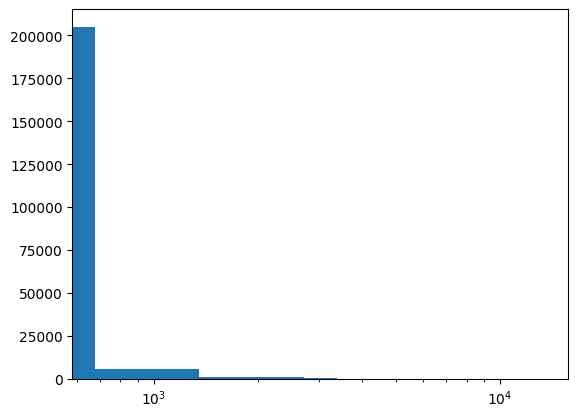

In [23]:
plt.hist(df.text_len, bins=20)
plt.xscale('log')

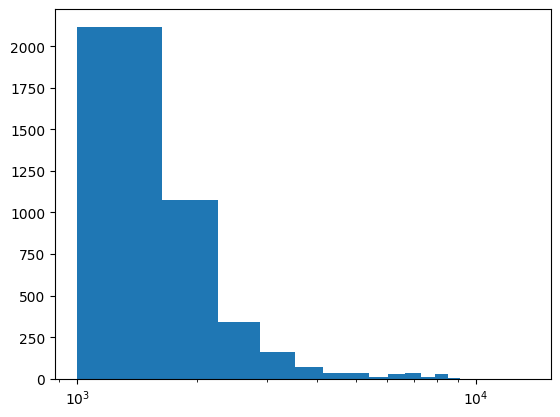

In [24]:
plt.hist(df[df.text_len > 1000].text_len, bins=20)
plt.xscale('log')

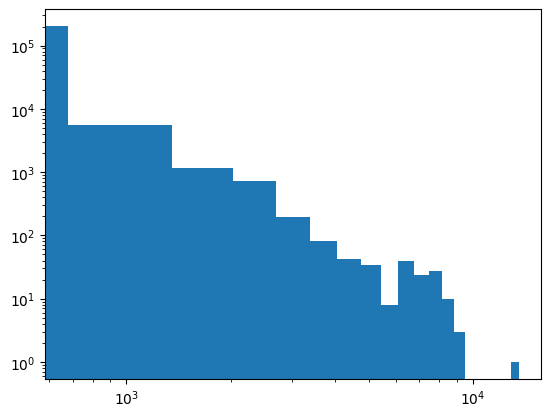

In [49]:
plt.hist(df.text_len, bins=20)
plt.xscale('log')
plt.yscale('log')

In [55]:
sum(df.text_len > 1000) / len(df)

0.018519474788633878

## Numbers in text

In [30]:
def count_number_sequences(input_string):
    # Use regular expression to find all sequences of digits
    digit_sequences = re.findall(r'\d+', input_string)
    
    # Count the number of digit sequences
    count = len(digit_sequences)
    
    return count

# Example usage:
input_str = "Hello123World456"
result_count = count_number_sequences(input_str)
print(f'The number of digit sequences in "{input_str}" is: {result_count}')


The number of digit sequences in "Hello123World456" is: 2


In [31]:
df['numbers_in_text'] = df.text.apply(count_number_sequences)

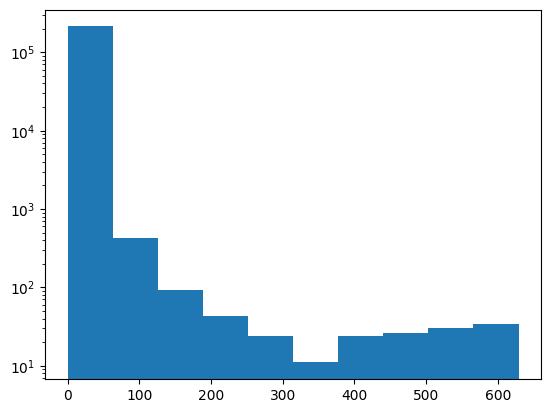

In [32]:
plt.hist(df.numbers_in_text)
plt.yscale('log')

In [35]:
post = df[df.numbers_in_text > 500].iloc[0].text

In [36]:
len(post)

7185

In [37]:
print(post)

Список актуален на 24 февраля 2023 года.Москва,отправки по РФ. 
 
РЕПТИЛИИ И АМФИБИИ: 
1)Аgama atra.Взрослая пара\15.000 (самки с половинками хвостов) 
Подростки н.о\6.000.Отдельно самцы\4000 
2)Сordylus niger.Взрослая пара\24.000,семья 1самец 2 самки\45.000 
Подростки без определения 12-15см\10.000 
Подростки без определения\неполные хвосты(отрастают)12-15см\8.000 
3)Рolypedates megacephalus 2-2.5 см\800,от 3 шт\600 F1 
4)Турецкие агамы(Laudakia stellio)Разводные\5 мес\6000 F1 
5)Anolis sagrei\1-2 мес\2000 F1 
6)Австралийские голубые квакши\2.5см\1200 
7)Хамелеоны:Bradypodion pumilum\6 см тело,16-17 с хвостом\8000,3шт\21.000 
 
ГЕККОНЫ: 
ПАРТЕНОГЕНЕТИЧЕСКИЕ(Lepidodactylus lugubris)+-1 мес\5 см\1200 
Hemidactylus triedurus\1-2 мес\5-6 см\1000 
Gekko vittatus\1 мес\3500 
 
СКОЛОПЕНДРЫ : 
Сormocephalus nitidus.L1-2\2500.Подростки5-7 см\4000 
Scolopendra subspinipes "black tip»L2-3\3000,от 3 шт\2500 
Scolopendra cf. subspinipes «Yellow Tiger L2-3\3000,от 3 шт\2500 
Scolopendra sp. «Mint l

In [66]:
df[df.numbers_in_text > 500].iloc[0]

text                    Список актуален на 24 февраля 2023 года.Москва...
vk_wall_id                                                      -63095842
vk_post_id                                                         472670
attachment_types                                                  [photo]
n_unique_attachments                                                    0
has_link                                                            False
text_len                                                             7185
numbers_in_text                                                       562
unique_symbols                                                        212
Name: 172296, dtype: object

In [40]:
sum(df.numbers_in_text == 0) / len(df)

0.06018711945882762

In [73]:
sum(df.numbers_in_text > 40) / len(df)

0.010355883747459146

## Unique symbols

In [58]:
def count_non_latin_cyrillic(input_string):
    valid_chars = set(string.ascii_letters + string.digits + string.punctuation + ' ' +
                      'абвгдежзийклмнопрстуфхцчшщъыьэюя' + 'АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ')

    count = 0
    for char in input_string:
        if char not in valid_chars:
            count += 1

    return count

# Example usage:
input_str = "Hello, 123!☺ Привет, мир!"
result = count_non_latin_cyrillic(input_str)
print(f'The number of non-Latin and non-Cyrillic symbols in "{input_str}" is: {result}')


The number of non-Latin and non-Cyrillic symbols in "Hello, 123!☺ Привет, мир!" is: 1


In [60]:
df['unique_symbols'] = df.text.apply(count_non_latin_cyrillic)

In [61]:
df.unique_symbols.describe()

count    213019.000000
mean          7.139429
std          10.264264
min           0.000000
25%           4.000000
50%           5.000000
75%           7.000000
max         786.000000
Name: text, dtype: float64

In [64]:
sum(df.unique_symbols > 30) / len(df)

0.02554232251583192

In [74]:
df[df.unique_symbols == 786]

,text,vk_wall_id,vk_post_id,attachment_types,n_unique_attachments,has_link,text_len,numbers_in_text,unique_symbols
194821,⠔ ꧁ ⦅ ─ ┃ 𝐍𝐄𝐖 𝐏𝐎𝐒𝐓 ┃ ─ ⦆ ꧂⠑\n\n╔ ═ ═ ═ ═ ═ ═ ═...,-48332904,727428,"[photo, link]",1,True,2596,51,786


In [122]:
limits_top = {
  'unique_symbols': 30,
  'numbers_in_text': 40,
  'text_len':1000,
}
limits_bool = {
  'has_link': False
}
limits_bot = {
  'numbers_in_text': 1,
}
mask = pd.Series(index=df.index, data=True)
for key, val in limits_top.items():
  mask &= df[key] <= val
for key, val in limits_bot.items():
  mask &= df[key] >= val
for key, val in limits_bool.items():
  mask &= df[key] == val
clean_df = df[mask]
(len(df) - len(clean_df)) / len(df)

0.1233504992512405

## wall id

In [123]:
clean_df.vk_wall_id.unique()

array([-209013890, -206817857, -203393330, -201484036, -192083416,
       -177461486, -151775338, -123125734, -114967596, -96362008,
       -90442795, -82544098, -63095842, -48332904, -6255826, -1485],
      dtype=object)

In [124]:
by_wall = df[['vk_wall_id', 'text']].groupby('vk_wall_id').count()
by_wall['ratio'] = by_wall['text'] / by_wall['text'].sum()
by_wall

,text,ratio
vk_wall_id,,
-209013890,35502,0.166661
-206817857,39587,0.185838
-203393330,47347,0.222267
-201484036,16688,0.078340
-192083416,4160,0.019529
-177461486,3408,0.015999
-151775338,295,0.001385
-123125734,1087,0.005103
-114967596,3109,0.014595


In [129]:
final_clean_df = clean_df.sample(n=10000, replace=False, random_state=RANDOM_SEED).reset_index(drop=True)
final_clean_df = final_clean_df[['text', 'vk_wall_id', 'vk_post_id']]
final_clean_df

,text,vk_wall_id,vk_post_id
0,Распродажа\nГель для душа \nЦена: 130р\nАрт: 2...,-203393330,129723
1,Цена: 50руб\nРаспродажа\nРазмер 92-104-116-128...,-206817857,108491
2,Распродажа \nДеревянный пазл микс\nЦена 150р ш...,-206817857,88819
3,Москва\nПродам годовалую самочку урартики свое...,-63095842,493818
4,Кроссовки Мужские \nЦена штучно 500р\nРазмер 4...,-203393330,86884
...,...,...,...
9995,Распродажа⚡\nДжинсовая куртка\nЦена: 500руб.\n...,-201484036,92531
9996,Распродажа\nЦена: 200р\nТкань: трикотаж\nРазме...,-203393330,125881
9997,Цена: 250руб\nРаспродажа\nРазмер 86-92-98-104-...,-206817857,95043
9998,"Пост 2\nЦветы ручной работы, наборы вырубки в ...",-6255826,618680


In [213]:
with open(CACHE_DIR + 'clean_df.pkl', 'wb') as f:
  pkl.dump(final_clean_df, f)

## Prompt testing df

In [216]:
ptdf = pd.DataFrame(columns=df.columns)

In [217]:
bigger_texts = clean_df[clean_df.text_len > 900].sample(n=2)
len(bigger_texts)

2

In [218]:
ptdf = pd.concat([ptdf, bigger_texts])
len(ptdf)

2

In [219]:
many_numbers = clean_df[clean_df.numbers_in_text > 35].sample(n=2)
len(many_numbers)

2

In [220]:
ptdf = pd.concat([ptdf, many_numbers])
len(ptdf)

4

In [221]:
special_symbols = clean_df[clean_df.unique_symbols > 28].sample(n=2)
len(special_symbols)

2

In [222]:
ptdf = pd.concat([ptdf, special_symbols])
len(ptdf)

6

In [223]:
several_numbers = clean_df[(clean_df.numbers_in_text < 10) & (clean_df.numbers_in_text > 8)].sample(n=2)
len(several_numbers)

2

In [224]:
ptdf = pd.concat([ptdf, several_numbers])
len(ptdf)

8

In [225]:
for t in df[df.numbers_in_text < 5].text[:1000]:
  # if len(t) > 10 and 'цена' not in t.lower() and 'рублей' not in t and 'руб' not in t and '0р.' not in t:
  print(t)
  print('===================')

Распродажа
Цена: 150руб.
Арт: 2В-23/1Б корпус А

Распродажа 
Полуавтоматический венчик для взбивания яиц, кухонный инструмент для выпечки
Цена: 100р 
АРТ: 6-06
Распродажа
Цена: 300руб.
Арт: 2Б-05/1А
Размеры: ЕДИНЫЙ
Выбор цвета: без выбора цвета
Начес: с начесом
Распродажа 
Скарлетт чайник
Цена: 399р
объём: 2лт
Арт: Ст8-06
Распродажа
Бомбочки для ванны
Цена: 50руб.
Арт: 2В-23-1Б
Распродажа
Маска от черных точек lanbena очищающая пор от акне сужение пор обновление кожи .
Цена: 110руб 
Арт: 6-23
https:/vk.com/club198062550
Распродажа
Основа под макияж трехцветная
Цена: 100р
АРТ: 6-06
Распродажа
Электрическая пемза для педикюра
Цена: 200р
Вес: 210 г
АРТ: 6-06
Распродажа
Тональный крем-кушон для лица
Цена: 100р 
АРТ: 9-98
Распродажа
Букет мыло роза
Без выбора цвета
Цена: 250р
Арт: 8-64
Распродажа 
Фен для волос 
Цена: 300р
Арт: 8-25
Распродажа
Цена: 150руб.
Арт: 2В-23/1Б корпус А
Распродажа 
Цена за 3шт: 100р 
БЕЗ ВЫБОРА 
АРТ: 7-15
Распродажа
Цена: 300руб.
Арт: 2Б-05/1А
Размеры: ЕДИНЫЙ
Выбо

In [226]:
print(df.text[996])

Распродажа
Цена: 350руб
Размеры: ЕДИНЫЙ
Без выбора цвета
Арт: 22-28


In [227]:
# no name
ptdf = pd.concat([ptdf, df.iloc[[996], :]])
len(ptdf)

9

In [228]:
# normal single product
ptdf = pd.concat([ptdf, df[(df.numbers_in_text < 5) & (df.text_len > 10)].iloc[[1], :]])
len(ptdf)

10

In [229]:
ptdf

,text,vk_wall_id,vk_post_id,attachment_types,n_unique_attachments,has_link,text_len,numbers_in_text,unique_symbols
184056,Жабы и лягушки \n \nВозможен обмен на лягушек:...,-63095842,510914,[photo],0,False,951,15,18
182319,Краснодар/отправки \n\nМорские коряги. \n\nПро...,-63095842,500647,[photo],0,False,912,1,16
177295,г. Москва\nВ продаже кальций и витамины для ре...,-63095842,486346,[photo],0,False,987,37,21
145796,Продам уставную форму для военки. Я ростом 190...,-177461486,50164,[photo],0,False,422,36,15
177826,😊Продаются малыши 2023 года\nПятнистые эублефа...,-63095842,488271,[photo],0,False,614,11,30
139989,Грандиозная распродажа\nКлассное Футболки с дл...,-192083416,11693,[photo],0,False,231,8,29
117067,Супер акция распродажаш💖\nЦена:800р штучно 🤩\n...,-203393330,139660,[photo],0,False,112,9,15
33902,"Распродажа \nЦена: 300р\nРазмеры: 48,50,52,54,...",-209013890,92782,[photo],0,False,114,9,5
996,Распродажа\nЦена: 350руб\nРазмеры: ЕДИНЫЙ\nБез...,-209013890,37651,[photo],0,False,67,3,4
10,Распродажа \nПолуавтоматический венчик для взб...,-209013890,36026,[photo],0,False,110,3,3


In [232]:
with open(CACHE_DIR + 'prompt_test_df.pkl', 'wb') as f:
  pkl.dump(ptdf, f)

In [233]:
len(cache.storage)

NameError: name 'cache' is not defined